In [1]:
# ML_in_Finance-G-learning-portfolio-optimization
# Author: Matthew Dixon
# Version: 1.1 (27.2.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# numpy=1.18.1, matplotlib=3.1.3, scipy=1.4.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

## G-learning for portfolio optimization 

Implementation of semi-analytical G-learning with quadratic rewards for portfolio optimization and wealth management

Note: currently only the setting for wealth management is implemented (this corresponds to use_for_WM = True

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline

import numpy as np
import time
from scipy import random, linalg

# To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')

In [4]:
class G_learning_portfolio_opt:
    
    def __init__(self, 
                 num_steps,
                 lambd, 
                 eta,
                 beta,
                 gamma, 
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns
                 asset_holdings, # array of shape num_steps x num_stocks
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=None):
        
        
        self.num_steps = num_steps
        self.lambd = lambd
        self.eta = eta
        self.beta = beta
        self.gamma = gamma
        self.use_for_WM = use_for_WM
        
        self.num_assets = exp_returns.shape[1]
        
        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == self.num_assets
        
        self.exp_returns = exp_returns # array of shape num_steps x num_stocks
        self.Sigma_r = Sigma_r # array of shape num_stocks x num_stocks
        
        self.x_vals = asset_holdings # array of shape num_steps x num_stocks
        
        if self.use_for_WM:
                self.target_portf = target_portf
                assert len(self.target_portf) == self.num_steps
                
        # allocate memory for coefficients of F- and G-functions
        self.F_xx = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.F_x = np.zeros((self.num_steps, self.num_assets))
        self.F_0 = np.zeros(self.num_steps)
        
        self.Q_xx = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_uu = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_ux = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_x = np.zeros((self.num_steps, self.num_assets))
        self.Q_u = np.zeros((self.num_steps, self.num_assets))
        self.Q_0 = np.zeros(self.num_steps)
        
        # optimal actions for all assets (only used for the final step)
        self.opt_action = np.zeros((self.num_steps, self.num_assets))
        
        # initialize time-dependent parameters of prior policy 
        self.u_bar_prior = np.zeros((self.num_steps,self.num_assets))
        self.v_bar_prior =  np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Sigma_prior =  np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Sigma_prior_inv = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        
        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * np.eye(self.num_assets)
            self.Sigma_prior[t,:,:] = 0.1 * np.eye(self.num_assets)
            self.Sigma_prior_inv[t,:,:] = np.linalg.inv(self.Sigma_prior[t,:,:])
        
    def set_terminal_conditions(self):
        
        # set the terminal condition for the F-function
        exp_ret_T = self.exp_returns[-1,:]
        exp_ret_T_v = exp_ret_T[:, np.newaxis]
        one_plus_exp_ret = np.ones(self.num_assets)[:,np.newaxis] + exp_ret_T_v
        if self.use_for_WM:
            Sigma_hat = self.Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
            Sigma_tilde = Sigma_hat + (self.eta/self.lambd)*np.eye(self.num_assets)
            
            # P_tilde is a column vector
            self.P_tilde = (self.target_portf[-1]*one_plus_exp_ret - 
                            (1.0/(2*self.lambd))*np.ones(self.num_assets)[:,np.newaxis]
                           )
        
            Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
            
            # compute P_aux ~= P_tilde - Sigma_hat.dot(x)
            P_aux_1 = Sigma_hat.dot(self.x_vals[-1,:])
            P_aux = self.P_tilde - P_aux_1[:,np.newaxis]
            
            # the last action
            self.opt_action[-1,:] = Sigma_tilde_inv.dot(P_aux.reshape(-1))
            
            # F_xx
            self.F_xx[-1,:,:] = (- self.lambd*Sigma_hat.dot(np.eye(self.num_assets)
                                                           - Sigma_tilde_inv.dot(Sigma_hat)))
            # F_x
            Sigma_hat_Sigma_til = Sigma_hat.dot(Sigma_tilde_inv)
            One_minus_Sigma_hat_til = np.eye(self.num_assets) - Sigma_hat_Sigma_til
            
            self.F_x[-1,:] =  (Sigma_hat_Sigma_til.dot(np.ones(self.num_assets))+ 
                               2*self.lambd*self.target_portf[-1]*
                               One_minus_Sigma_hat_til.dot(one_plus_exp_ret.reshape(-1)))
            
            # F_0
            P_tilde_Sigma_aux = self.P_tilde.reshape(-1).dot(Sigma_tilde_inv)
            Sigma_P_tilde_aux = Sigma_tilde_inv.dot(self.P_tilde.reshape(-1))
            P_T = self.target_portf[-1]
            
            self.F_0[-1] = (P_tilde_Sigma_aux.dot(np.ones(self.num_assets))
                            - self.lambd * P_tilde_Sigma_aux.dot(self.P_tilde.reshape(-1))
                            + 2*self.lambd * one_plus_exp_ret.reshape(-1).dot(Sigma_P_tilde_aux)
                            - self.lambd * P_T**2)
            
    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy
        
        """
        
        # set terminal conditions
        self.set_terminal_conditions()
        
        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)
        
        # iterate over time steps backward
        for t in range(self.num_steps-2,-1,-1):
            self.step_G_learning(t, err_tol, max_iter)
            
    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """
            
        # local variables
        F_xx_tp1 = self.F_xx[t+1,:,:]
        F_x_tp1 = self.F_x[t+1,:]
        F_0_tp1 = self.F_0[t+1]
            
        # make matrix Sigma_hat_t
        exp_ret_T = self.exp_returns[t,:]  
        exp_ret_T_v = exp_ret_T[:, np.newaxis]
        one_plus_exp_ret = np.ones(self.num_assets)[:,np.newaxis] + exp_ret_T_v
        Sigma_hat_t = self.Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
            
        # matrix A_t = diag(1 + r_bar_t)
        A_t = np.diag(np.ones(self.num_assets) + exp_ret_T)
                    
        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t,Sigma_hat_t)
             
        # iterate between policy evaluation and policy improvement  
        while self.iter_counts[t] < max_iter:
                
            curr_u_bar_prior = self.u_bar_prior[t,:].copy() 
            curr_v_bar_prior = self.v_bar_prior[t,:,:].copy()    
                
            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t) 
              
            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)    
            
            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = np.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)
            
            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*np.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)
            
            # choose the difference from the previous iteration as the maximum of the two errors
            tol = 0.5*(err_u_bar + err_v_bar)
                        
            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break

            
    def update_Q_params(self,t, A_t,Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """ 
        
        self.Q_xx[t,:,:] = ( - self.lambd * Sigma_hat_t 
                            + self.gamma*( (A_t.dot(self.F_xx[t+1,:,:])).dot(A_t)  
                                           + self.Sigma_r * self.F_xx[t+1,:,:] ) )
        
        self.Q_ux[t,:,:] = 2 * self.Q_xx[t,:,:]
        
        self.Q_uu[t,:,:] = self.Q_xx[t,:,:] - self.eta * np.eye(self.num_assets)
        
        self.Q_x[t,:] = (self.lambd * self.target_portf[t] * A_t.dot(np.ones(self.num_assets))
                             + self.gamma * A_t.T.dot(self.F_x[t+1,:]) )
        
        self.Q_u[t,:] = self.Q_x[t,:] - np.ones(self.num_assets)
        
        self.Q_0[t] = self.gamma * self.F_0[t+1] - self.lambd * self.target_portf[t]**2
        
        
    def update_F_params(self,t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy
        
        """
        
        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        U_t = self.beta * self.Q_ux[t,:,:] + self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])
        W_t = self.beta * self.Q_u[t,:] +  self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])
        Sigma_p_bar =  self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_p_bar_inv = np.linalg.pinv(Sigma_p_bar)
        
        # update parameters of F-function
        self.F_xx[t,:,:] = self.Q_xx[t,:,:] + (1/(2*self.beta))*(U_t.T.dot(Sigma_p_bar_inv.dot(U_t))
                                    - self.v_bar_prior[t,:,:].T.dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])))
        
        
        self.F_x[t,:] = self.Q_x[t,:] + (1/self.beta)*(U_t.T.dot(Sigma_p_bar_inv.dot(W_t))
                                    - self.v_bar_prior[t,:,:].T.dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])))
        
        
        self.F_0[t] = self.Q_0[t] + ( (1/(2*self.beta))*(W_t.dot(Sigma_p_bar_inv.dot(W_t))
                                    - self.u_bar_prior[t,:].dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])))
                                    - (1/(2*self.beta)) * (np.log(np.linalg.det(self.Sigma_prior[t,:,:]))
                                                       + np.log(np.linalg.det(Sigma_p_bar))) )
        
    def update_policy_params(self,t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """
        
        self.Sigma_prior_inv[t,:,:] = self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_prior_new = np.linalg.pinv(self.Sigma_prior_inv[t,:,:])
        
        self.u_bar_prior[t,:] = Sigma_prior_new.dot(self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])
                                              + self.beta * self.Q_u[t,:])
        
        self.v_bar_prior[t,:,:] = Sigma_prior_new.dot(self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])
                                              - self.beta * self.Q_ux[t,:,:])
        
        # assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new
        
        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:]
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:]
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:]
        
               

In [5]:
# test using random and meaningless inputs

num_steps = 10 
num_assets = 100
lambd = 1.0
eta = 0.5
beta = 0.2
gamma = 0.95

exp_returns = np.random.randn(num_steps,num_assets)
Sigma_r = np.cov(exp_returns.T)
asset_holdings = np.random.random_integers(low=1, high=10, size=(num_steps,num_assets))
target_portf = np.linspace(start=1,stop=2, num = num_steps)

G_learner = G_learning_portfolio_opt(num_steps,
                 lambd, 
                 eta,
                 beta,
                 gamma,                    
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns
                 asset_holdings, # array of shape num_steps x num_stocks
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=target_portf)

### Do the G-learning

In [6]:
err_tol=5.0e-5 # 1.0e-4
max_iter=300

t_0 = time.time()

G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)

# print('Done in %d iterations'% G_learner.iter_count)
print('Done in %f sec'% (time.time() - t_0))

Done in 12.161226 sec


In [7]:
G_learner.iter_counts

array([300., 300., 115., 106., 135., 146., 174., 146., 300.,   0.])

In [8]:
G_learner.u_bar_prior[6:8,0:8]

array([[ 0.25966336,  0.49430843, -0.74774777, -0.59642827, -0.42921178,
        -0.92598568, -0.36058915,  0.44650461],
       [-0.49953031, -0.9611446 , -1.03911031, -0.39389504, -1.44409505,
        -0.91085633, -0.10059318, -0.90631267]])

Compute predicted cash installments for all steps



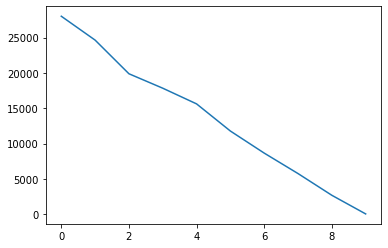

In [9]:
c_t = np.zeros(num_steps)
for t in range(num_steps):
    c_t[t] = np.sum(G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:,:].dot(asset_holdings[t,:]))

plt.plot(c_t);

In [10]:
ar = np.array([0,1,2]).reshape((-1,1))

ar.shape

(3, 1)

In [11]:
### Try to modify the class, the initial copy is saved above


class G_learning_portfolio_opt:
    
    def __init__(self, 
                 num_steps,
                 lambd, 
                 Omega_mat, # of shape (num_risky_assets + 1)x(num_risky_assets + 1) # eta,
                 beta,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix
                 asset_holdings, # array of shape num_steps x (num_stocks + 1)
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=None):
        
        
        self.num_steps = num_steps
        self.lambd = lambd
        
        #self.eta = eta
        self.Omega_mat = Omega_mat
        
        self.beta = beta
        self.gamma = gamma
        self.use_for_WM = use_for_WM
        
        self.num_risky_assets = num_risky_assets
        self.r_f = riskfree_rate
        
        self.num_assets = num_risky_assets + 1 # exp_returns.shape[1]
        
        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == num_risky_assets # self.num_assets
        
        self.Sigma_r = Sigma_r # array of shape num_stocks x num_stocks
        
        # arrays of returns for all assets including the risk-free asset
        # array of shape num_steps x (num_stocks + 1) 
        self.exp_returns = np.hstack((self.r_f * np.ones(self.num_steps).reshape((-1,1)), exp_returns))
                                      
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        self.Sigma_r_tilde = np.zeros((self.num_assets, self.num_assets))
        self.Sigma_r_tilde[1:,1:] = self.Sigma_r
        
        # asset_holdings is a vector for both the bond and all stocks
        self.x_vals = asset_holdings # array of shape num_steps x (num_stocks+1)
        
        if self.use_for_WM:
                self.target_portf = target_portf
                assert len(self.target_portf) == self.num_steps
#       else:
#           raise (RuntimeError, "A target portfolio profile is required")
                
        # allocate memory for coefficients of F- and G-functions
        self.F_xx = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.F_x = np.zeros((self.num_steps, self.num_assets))
        self.F_0 = np.zeros(self.num_steps)
        
        self.Q_xx = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_uu = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_ux = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_x = np.zeros((self.num_steps, self.num_assets))
        self.Q_u = np.zeros((self.num_steps, self.num_assets))
        self.Q_0 = np.zeros(self.num_steps)
        
        # optimal actions for all assets (only used for the final step)
        self.opt_action = np.zeros((self.num_steps,self.num_assets))
        
        # initialize time-dependent parameters of prior policy 
        self.u_bar_prior = np.zeros((self.num_steps,self.num_assets))
        self.v_bar_prior =  np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Sigma_prior =  np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Sigma_prior_inv = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        
        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * np.eye(self.num_assets)
            self.Sigma_prior[t,:,:] = 0.1 * np.eye(self.num_assets)
            self.Sigma_prior_inv[t,:,:] = np.linalg.inv(self.Sigma_prior[t,:,:])
            
        # cash installment for all steps
        self.c_t = np.zeros(self.num_steps)
    
    def reward_fun(self, t, x_vals, u_vals, exp_rets, lambd, Sigma_hat):
        """
        The reward function. Currently not used in the code, the reward enters directly in other functions 
        """
        x_plus = x_vals + u_vals
        aux_1 = - self.lambd * self.target_portf[t]**2
        aux_2 = - np.sum(u_vals)
        aux_3 = 2*self.lambd * self.target_portf[t] * x_plus.dot(np.ones(num_assets) + exp_rets)
        aux_4 = - self.lambd * x_plus.dot(Sigma_hat.dot(x_plus))
        aux_5 = - u.dot(self.Omega_mat.dot(u))
        
        return aux_1 + aux_2 + aux_3 + aux_4 + aux_5  
    
    def set_terminal_conditions(self):
        """
        set the terminal condition for the F-function
        """
        
        # auxiliary quantities to perform matrix calculations
        exp_ret_T = self.exp_returns[-1,:]
        exp_ret_T_v = exp_ret_T[:, np.newaxis]
        one_plus_exp_ret = np.ones(self.num_assets)[:,np.newaxis] + exp_ret_T_v
        
        if self.use_for_WM:
            # Sigma_hat = self.Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
            Sigma_hat = self.Sigma_r_tilde + one_plus_exp_ret.dot(one_plus_exp_ret.T)
            
            Sigma_hat_inv = np.linalg.pinv(Sigma_hat)
            
            #Sigma_tilde = Sigma_hat + (self.eta/self.lambd)*np.eye(self.num_assets)
            Sigma_tilde = Sigma_hat + (1/self.lambd)*self.Omega_mat
            
            Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
            
            Sigma_hat_sigma_tilde = Sigma_hat.dot(Sigma_tilde)
            Sigma_tilde_inv_sig_hat = Sigma_tilde_inv.dot(Sigma_hat)
            
            Sigma_tilde_sigma_hat = Sigma_tilde.dot(Sigma_hat)
            
            Theta_m = np.eye(self.num_assets) - Sigma_tilde_inv.dot(Sigma_hat) 
            
            P_T = self.target_portf[-1]
    
            # P_tilde is a column vector
            P_tilde = P_T * one_plus_exp_ret - (1.0/(2*self.lambd))*np.ones(self.num_assets)[:,np.newaxis]
                           
            # compute P_aux \equiv P_tilde - Sigma_hat.dot(x)
            P_aux_1 = Sigma_hat.dot(self.x_vals[-1,:])
            P_aux = P_tilde - P_aux_1[:,np.newaxis]
            
            # the last action
            self.opt_action[-1,:] = Sigma_tilde_inv.dot(P_aux.reshape(-1))
            
            # though the action at the last step is deterministic, we can feed 
            # parameters of the prior with these values
            self.u_bar_prior[-1,:] = Sigma_tilde_inv.dot(P_tilde.reshape(-1))
            self.v_bar_prior[-1,:,:] = - Sigma_tilde_inv.dot(Sigma_hat)
            
            self.c_t[-1] = np.sum(self.opt_action[-1,:])
            
            # the coefficients of F-function for the last step
            
            # F_xx
            self.F_xx[-1,:,:] = (- self.lambd * Theta_m.T.dot(Sigma_hat.dot(Theta_m))
                                 - Sigma_tilde_inv_sig_hat.T.dot(self.Omega_mat.dot(Sigma_tilde_inv_sig_hat))
                                 )
                                 
                                 
            
            # F_x
            Sigma_hat_Sigma_tilde_inv = Sigma_hat.dot(Sigma_tilde_inv)
            
            aux_1x = Sigma_hat_Sigma_tilde_inv.dot(np.ones(self.num_assets))
            aux_2x = 2*self.lambd * P_T * Theta_m.T.dot(one_plus_exp_ret.reshape(-1))
            aux_3x = - 2*self.lambd * (Theta_m.T.dot(Sigma_hat_Sigma_tilde_inv.dot(P_tilde))).reshape(-1)
            aux_4x = 2 * (Sigma_hat_Sigma_tilde_inv.dot(self.Omega_mat.dot(Sigma_tilde_inv.dot(P_tilde)))).reshape(-1)
    
    
            self.F_x[-1,:] = aux_1x + aux_2x + aux_3x + aux_4x
        
            # F_0
            P_tilde_Sigma_aux = P_tilde.reshape(-1).dot(Sigma_tilde_inv)
            Sigma_P_tilde_aux =  Sigma_tilde_inv.dot(P_tilde.reshape(-1)) # P_tilde_Sigma_aux.T #
            
            
            aux_0 = - self.lambd * P_T**2
            aux_1 =  - P_tilde.T.dot(Sigma_tilde_inv.dot(np.ones(self.num_assets)))[0] # this is a matrix of size 1x1        
            aux_2 = 2*self.lambd * P_T * one_plus_exp_ret.reshape(-1).dot(Sigma_P_tilde_aux)
            aux_3 = - self.lambd * P_tilde_Sigma_aux.dot(Sigma_hat.dot(Sigma_P_tilde_aux))
            aux_4 =  -  P_tilde_Sigma_aux.dot(self.Omega_mat.dot(Sigma_P_tilde_aux))
    
            #print('In set_terminal_conditions: shapes')
            #print(aux_1.shape, aux_2.shape, aux_3.shape, aux_4.shape)
            #print('aux_1 = ', aux_1)
        
            self.F_0[-1] =  aux_0 + aux_1 + aux_2 + aux_3 + aux_4
            
            #print('self.F_0[-1]: done')

#             self.F_0[-1] = (- self.lambd * P_T**2 
#                             - P_tilde.T.dot(Sigma_tilde_inv.dot(np.ones(self.num_assets)))
#                             + 2*self.lambd * P_T * one_plus_exp_ret.reshape(-1).dot(
#                                                     Sigma_P_tilde_aux.dot(P_tilde.reshape(-1)))
#                             - self.lambd * P_tilde_Sigma_aux.dot(Sigma_hat.dot(Sigma_P_tilde_aux)) 
#                             -  P_tilde_Sigma_aux.dot(self.Omega_mat.dot(Sigma_P_tilde_aux))
                           
#                             )

            
            
    
    
    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy
        
        """
        
        print('Doing G-learning, it may take a few seconds...')
        
        # set terminal conditions
        self.set_terminal_conditions()
        
        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)
        
        # iterate over time steps backward
        for t in range(self.num_steps-2,-1,-1):
            self.step_G_learning(t, err_tol, max_iter)
            
    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """
            
        # local variables
        F_xx_tp1 = self.F_xx[t+1,:,:]
        F_x_tp1 = self.F_x[t+1,:]
        F_0_tp1 = self.F_0[t+1]
            
        # make matrix Sigma_hat_t
        exp_ret_T = self.exp_returns[t,:]  
        exp_ret_T_v = exp_ret_T[:, np.newaxis]
        one_plus_exp_ret = np.ones(self.num_assets)[:,np.newaxis] + exp_ret_T_v
        
        # Sigma_hat_t = self.Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
        Sigma_hat_t = self.Sigma_r_tilde + one_plus_exp_ret.dot(one_plus_exp_ret.T)
        
        # matrix A_t = diag(1 + r_bar_t)
        A_t = np.diag(np.ones(self.num_assets) + exp_ret_T)
                    
        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t,Sigma_hat_t)
             
        # iterate between policy evaluation and policy improvement  
        while self.iter_counts[t] < max_iter:
                
            curr_u_bar_prior = self.u_bar_prior[t,:].copy() 
            curr_v_bar_prior = self.v_bar_prior[t,:,:].copy()    
                
            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t) 
              
            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)    
            
            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = np.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)
            
            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*np.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)
            
            # choose the difference from the previous iteration as the maximum of the two errors
#             tol = np.minimum(err_u_bar, err_v_bar)
#             tol = np.maximum(err_u_bar, err_v_bar)
            tol = 0.5*(err_u_bar + err_v_bar)
            
            #print('err_u_bar, err_v_bar, tol', err_u_bar, err_v_bar, tol)
            
            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break
                
        self.c_t[t] = np.sum(self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].dot(self.x_vals[t,:]))

            
    def update_Q_params(self,t, A_t,Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """ 
        
#         self.Q_xx[t,:,:] = ( - self.lambd * Sigma_hat_t 
#                             + self.gamma*( (A_t.dot(self.F_xx[t+1,:,:])).dot(A_t)  
#                                            + self.Sigma_r * self.F_xx[t+1,:,:] ) )
        
        self.Q_xx[t,:,:] = ( - self.lambd * Sigma_hat_t 
                            + self.gamma*( (A_t.dot(self.F_xx[t+1,:,:])).dot(A_t)  
                                           + self.Sigma_r_tilde * self.F_xx[t+1,:,:] ) )
        
        
        self.Q_ux[t,:,:] = 2 * self.Q_xx[t,:,:]
        
        #self.Q_uu[t,:,:] = self.Q_xx[t,:,:] - self.eta * np.eye(self.num_assets)
        self.Q_uu[t,:,:] = self.Q_xx[t,:,:] - self.Omega_mat 
        
        self.Q_x[t,:] = (self.lambd * self.target_portf[t] * A_t.dot(np.ones(self.num_assets))
                             + self.gamma * A_t.T.dot(self.F_x[t+1,:]) )
        
        self.Q_u[t,:] = self.Q_x[t,:] - np.ones(self.num_assets)
        
        self.Q_0[t] = self.gamma * self.F_0[t+1] - self.lambd * self.target_portf[t]**2
        
        
    def update_F_params(self,t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy
        
        """
        
        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        U_t = self.beta * self.Q_ux[t,:,:] + self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])
        W_t = self.beta * self.Q_u[t,:] +  self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])
        Sigma_p_bar =  self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_p_bar_inv = np.linalg.pinv(Sigma_p_bar)
        
        # update parameters of F-function
        self.F_xx[t,:,:] = self.Q_xx[t,:,:] + (1/(2*self.beta))*(U_t.T.dot(Sigma_p_bar_inv.dot(U_t))
                                    - self.v_bar_prior[t,:,:].T.dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])))
        
        
        self.F_x[t,:] = self.Q_x[t,:] + (1/self.beta)*(U_t.T.dot(Sigma_p_bar_inv.dot(W_t))
                                    - self.v_bar_prior[t,:,:].T.dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])))
        
        
        self.F_0[t] = self.Q_0[t] + ( (1/(2*self.beta))*(W_t.dot(Sigma_p_bar_inv.dot(W_t))
                                    - self.u_bar_prior[t,:].dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])))
                                    - (1/(2*self.beta)) * (np.log(np.linalg.det(self.Sigma_prior[t,:,:]))
                                                       + np.log(np.linalg.det(Sigma_p_bar))) )
        
    def update_policy_params(self,t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """
        
        new_Sigma_prior_inv = self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_prior_new = np.linalg.pinv(new_Sigma_prior_inv)
        
        
        # update parameters using the previous value of Sigma_prior_inv
        self.u_bar_prior[t,:] = Sigma_prior_new.dot(self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])
                                              + self.beta * self.Q_u[t,:])
        
        
        self.v_bar_prior[t,:,:] = Sigma_prior_new.dot(self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])
                                              + self.beta * self.Q_ux[t,:,:])
        
        # and then assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new
        self.Sigma_prior_inv[t,:,:] = new_Sigma_prior_inv
        
        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:]
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:]
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:]
        


In [12]:
# adjusted test

# test using random and meaningless inputs

num_steps = 5 # 10 # 2 # 5 # 

num_risky_assets = 99 # num_assets = 100 
riskfree_rate = 0.02 # 0.1

In [13]:
# np.random.seed(42)

exp_returns = np.random.randn(num_steps,num_risky_assets)
Sigma_r = np.cov(exp_returns.T)


# current portfolio: random values
ref_val = 1
x_vals = ref_val * np.ones((num_steps,num_assets))
noise_coeff_p = 0.8
noise_factors = np.random.uniform(low=1-noise_coeff_p, high=1+noise_coeff_p, size=(num_steps,num_assets))
x_vals = noise_factors * x_vals

In [14]:
portf_val = x_vals.sum(axis=1)
print(portf_val)

[108.78850407 101.79869387 106.32500641  97.42720363 101.45957073]


In [15]:
# parameters of transaction cost

# eta = 0.5

fee_bond = 0.05
fee_stock = 0.1 # 1.0 # 100 # 1.0 # 0.5 

# noticed much worse convergence for fee_stock = 0.2
# it converges for fee_stock = 0.5, but it converges faster for fee_stock=1

all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)


# model parameters
lambd = 1.0 # 0.02 # 0.05 # 0.07 # 0.1 # 0.15 # 0.1 # 0.15 # 0.1 # 0.1 # 50 # 10.0
beta = 0.5 # 1.0 # 50 # 50.0 # 1.0 # 10 # 10.0 # 0.2
gamma = 0.95

lambd = 10000 # 2000 # 0.01 # 0.05 # 0.5 # 0.1 # 1.0
beta = 10 # 1.0 # 0.2 # 0.1 # 0.2

# make target portfolio to be a fixed fraction above the current portfolio value
coeff_target = 1.8 # 1.2 # 2.0 # 1.5 # 1.2
portf_val = x_vals.sum(axis=1)
target_portf = coeff_target * portf_val


G_learner = G_learning_portfolio_opt(num_steps,
                 lambd, 
                 Omega_mat, # eta,
                 beta,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix                    
                 x_vals, # array of shape num_steps x num_stocks
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=target_portf)

In [16]:
# Do G-learning

err_tol= 1.e-4 # 3.e-4 # 1e-4 # 3.5e-3 # 1.0e-4
max_iter=500

t_0 = time.time()

G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)

print('Done in %f sec'% (time.time() - t_0))

Doing G-learning, it may take a few seconds...
Done in 3.528143 sec


In [17]:
G_learner.iter_counts

array([220., 100.,  70.,  91.,   0.])

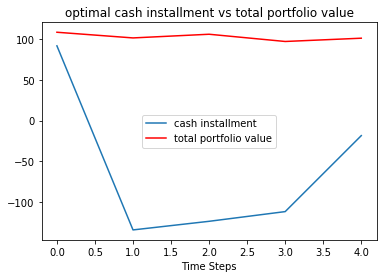

In [18]:
# compute predicted cash installments for all steps

c_t = np.zeros(num_steps)
for t in range(num_steps):
#     c_t[t] = np.sum(G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:,:].dot(x_vals[t,:]))
    c_t[t] = G_learner.c_t[t]
plt.plot(c_t, label='cash installment')
plt.plot(x_vals.sum(axis=1),label='total portfolio value', color ='r')

plt.legend()
plt.xlabel('Time Steps')
plt.title('optimal cash installment vs total portfolio value')

plt.show()

In [19]:
c_t[-2:]

array([-111.90728542,  -18.4227222 ])

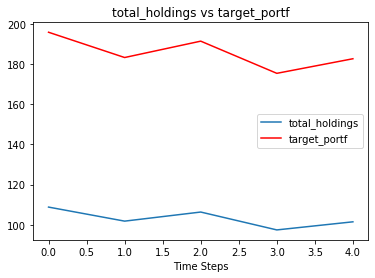

In [20]:
# compare the target portfolio and total holdings

total_holdings = x_vals.sum(axis=1)

plt.plot(total_holdings,label='total_holdings')
plt.plot(target_portf,label='target_portf',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('total_holdings vs target_portf')
plt.show()

## Develop intuition for a one-period setting

In [21]:
step_size = 0.5 # semi-annual steps
vol_market_ann = 0.2 # annualized vol
num_stocks = 99
num_risky_assets = num_stocks
num_assets = num_stocks + 1

vol_market = vol_market_ann * np.sqrt(step_size)

# use a diagonal covariance matrix
Sigma_r = (vol_market**2) * np.eye(num_stocks)

Sigma_r_tilde = np.zeros((num_assets, num_assets))
Sigma_r_tilde[1:, 1:] = Sigma_r

# risk-free rate
r_f = 0.02

fee_bond = 0.05 # 1.0 # 0.1
fee_stock = 0.1 # 10.0 # 1.0 # 100 # 1.0 # 0.5 

# noticed much worse convergence for fee_stock = 0.2
# it converges for fee_stock = 0.5, but it converges faster for fee_stock=1

all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)

# model parameters
lambd = 2000 # 500 # 50.0 # 30.0 # 0.05 # 0.5 # 0.1 # 1.0
beta = 0.2
gamma = 0.95

# current portfolio: random values
# ref_val = 1
# x_vals = ref_val * np.ones(num_assets)
# noise_coeff_p = 0.8
# noise_factors = np.random.uniform(low=1-noise_coeff_p, high=1+noise_coeff_p, size=num_assets)
# x_vals = noise_factors * x_vals

# take the values from the previous simulation
x_vals_one_step = x_vals[-1,:]

# make target portfolio to be a fixed fraction above the current portfolio value

coeff_target = 1.2
portf_val_one_step = np.sum(x_vals_one_step)
target_portf_one_step = coeff_target * portf_val_one_step

def reward_fun(x_vals, u, exp_rets, lambd, Sigma_hat, Omega_mat, target_portf):
    x_plus = x_vals + u
    aux_1 = - lambd * target_portf**2
    aux_2 = - np.sum(u)
    aux_3 = 2*lambd * target_portf * x_plus.dot(np.ones(num_assets) + exp_rets)
    aux_4 = - lambd * x_plus.dot(Sigma_hat.dot(x_plus))
    aux_5 = - u.dot(Omega_mat.dot(u))
    
    print(aux_1,aux_2,aux_3,aux_4,aux_5)
    
    return aux_1 + aux_2 + aux_3 + aux_4 + aux_5

# make random returns

# exp_rets = 0.05 * np.ones(num_stocks)
# noise_coeff_r = 0.8
# noise_factors = np.random.uniform(low=1-noise_coeff_r, high=1+noise_coeff_r, size=num_stocks)
# exp_rets = noise_factors * exp_rets

# use the values from the previous simulation
exp_rets_one_step = exp_returns[-1,:]

# add the risk-free rate
exp_rets_one_step = np.hstack((np.array([r_f]), exp_rets_one_step))

exp_ret_T_one_step = exp_rets_one_step 
exp_ret_T_v_one_step = exp_ret_T_one_step[:, np.newaxis]
one_plus_exp_ret = np.ones(num_assets)[:,np.newaxis] + exp_ret_T_v_one_step

# compute the optimal action

Sigma_hat = Sigma_r_tilde + one_plus_exp_ret.dot(one_plus_exp_ret.T)
Sigma_tilde = Sigma_hat + (1/lambd)* Omega_mat
            
# P_tilde is a column vector
P_tilde = target_portf_one_step * one_plus_exp_ret - (1.0/(2*lambd))*np.ones(num_assets)[:,np.newaxis]

Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
            
# compute P_aux \equiv P_tilde - Sigma_hat.dot(x)
P_aux_1 = Sigma_hat.dot(x_vals_one_step)
P_aux = P_tilde - P_aux_1[:,np.newaxis]
            
# the optimal action
u_opt = Sigma_tilde_inv.dot(P_aux.reshape(-1))

x_vals_new = x_vals_one_step + u_opt

new_port_val = np.sum(x_vals_new)

optimal_cash_inflow = np.sum(u_opt)

# calculate the optimal cash inflow in a different way
u_bar_prior = Sigma_tilde_inv.dot(P_tilde.reshape(-1))# .reshape(-1)
v_bar_prior = - Sigma_tilde_inv.dot(Sigma_hat) # .reshape(-1)

print(u_bar_prior.shape, v_bar_prior.shape)

optimal_cash_inflow_2 = np.sum(u_bar_prior + v_bar_prior.dot(x_vals_one_step))

(100,) (100, 100)


In [22]:
reward_opt = reward_fun(x_vals_one_step, u_opt, exp_rets_one_step, lambd, Sigma_hat, 
                        Omega_mat, target_portf_one_step)
reward_zero = reward_fun(x_vals_one_step, np.zeros(num_assets), exp_rets_one_step, lambd, Sigma_hat, 
                         Omega_mat, target_portf_one_step)

print('exp_returns[0:5]:', exp_rets[0:5])

print('init portfolio value:', portf_val_one_step)
print('target portfolio:', target_portf_one_step)
print('optimal cash installment:',optimal_cash_inflow)
print('optimal cash installment_2:',optimal_cash_inflow_2)
print('new portfolio value:', new_port_val)
print('optimal reward:', reward_opt)
print('suboptimal reward:', reward_zero)


-29646848.139696203 -5.195965498353644 59292465.16724633 -29645739.339028172 -443.69376585160046
-29646848.139696203 -0.0 51159226.92660588 -22075185.978339173 -0.0


NameError: name 'exp_rets' is not defined

## Simulate portfolio data

### Simulate the market factor as a lognormal with a fixed drift and vol

In [ ]:
mu_market = 0.05
vol_market = 0.25
init_market_val = 100.0

r_rf = 0.03  # risk-free rate - the first asset will be cash

num_steps = 10 
dt = 0.25 # quarterly time steps

num_assets = 100

returns_market = np.zeros(num_steps)
market_vals = np.zeros(num_steps)
market_vals[0] = 100.0  # initial value


        
for t in range(1,num_steps):

        rand_norm = np.random.randn()
        
        # use log-returns of market as 'returns_market'
        returns_market[t] = mu_market * dt + vol_market * np.sqrt(dt) * rand_norm
        
        market_vals[t] = market_vals[t-1] * np.exp((mu_market - 0.5*vol_market**2)*dt + 
                                                         vol_market*np.sqrt(dt)*rand_norm)
        

In [ ]:
plt.plot(market_vals)

### Simulate market betas and idiosyncratic alphas within pre-defined ranges

In [ ]:
beta_min = 0.05
beta_max = 0.85

beta_vals = np.random.uniform(low=beta_min, high=beta_max, size=num_assets)

alpha_min = - 0.05
alpha_max = 0.15

alpha_vals = np.random.uniform(low=alpha_min, high=alpha_max, size=num_assets)

# Note: values beta_vals[0], alpha_vals[0] will be discarded as the first asset will be cash

print(beta_vals[0:10])
print(alpha_vals[0:10])

### Simulate time-dependent expected returns

In [ ]:
# time-independent expected returns would be equal to alpha + beta * expected_market_return 
# make them time-dependent (and correlated with actual returns) as alpha + beta * oracle_market_returns
# oracle expected returns pick into the future! 

oracle_coeff = 0.2
mu_vec = mu_market * np.ones(num_steps)
oracle_market_returns = mu_vec * dt + oracle_coeff*(returns_market - mu_vec) 

expected_returns = np.zeros((num_steps, num_assets))

for t in range(num_steps):
    expected_returns[t,:] = alpha_vals * dt + beta_vals * oracle_market_returns[t]
    # override the first value as the first asset is cash
    expected_returns[t,0] = r_rf * dt

In [ ]:
plt.plot(expected_returns[:,4])

### Initial values of all assets 

In [ ]:
val_min = 20.0
val_max = 120.0

init_asset_vals = np.random.uniform(low=val_min, high=val_max, size=num_assets)


### Simulate realized returns and asset prices

In [ ]:
# make realized returns and realized asset values by simulating from a one-factor model 
# with time-dependent expected returns

asset_returns = np.zeros((num_steps, num_assets))
asset_vals = np.zeros((num_steps, num_assets))

idiosync_vol = 0.02 # vol_market # 

for t in range(num_steps):
    
    rand_norm = np.random.randn(num_assets)
        
    # asset returns are simulated from a one-factor model
    asset_returns[t,:] = (expected_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
    # asset values
    if t == 0:
        asset_vals[t,:] = init_asset_vals
    else:
        asset_vals[t] = asset_vals[t-1] * (1 + asset_returns[t,:])
   


In [ ]:
t = 1
print(expected_returns[t,0:6])
print(beta_vals[0:6] * (returns_market[t] - mu_market*dt)) 
# print(beta_vals[0:6] * (returns_market[t])) 
print(idiosync_vol * (np.sqrt(1 - beta_vals[0:6]**2) * np.sqrt(dt) * rand_norm[0:6]))

In [ ]:
# compare the realized and expected returns
# Note that they appear correlated - this is because we constructed them so

# pick asset to show
asset_idx =  4 # 8 # 6 # 5

plt.plot(expected_returns[:,asset_idx],label='expected_return')
plt.plot(asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized returns vs expected returns')
plt.show()


### Compute the empirical correlation matrix using realized returns

In [ ]:
cov_mat_r = np.cov(asset_returns.T) # + shrink_coeff*np.eye(num_assets)

print(cov_mat_r.shape)

D,v = np.linalg.eigh(cov_mat_r)
# help(np.linalg.eigh)

eigenvals = D[::-1]  # put them in a descended order

In [ ]:
# the largest eigenvalue is the market factor 
eigenvals[0:10]

In [ ]:
# plot the histogram of eigenvalues

n, bins, patches = plt.hist(x=eigenvals, bins=12, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
# n, bins, patches = plt.hist(x=eigenvals, bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)



plt.grid(axis='y', alpha=0.75)

# x = np.arange(1,len(eigenvals)+1)
# y = eigenvals
# plt.scatter(x,y)
plt.xlabel('Eigenvalues')
plt.ylabel('Counts')
plt.title('Eigenvalues of the synthetic covariance matrix')
plt.show()

### Make the initial portfolio 

In [ ]:
# consider here two choices: an equally-weighted and price-weighted portfolio

init_port_choice = 'equally_weighted'  # 'equal'

init_cash = 1000.0
init_total_asset = np.sum(init_asset_vals)

# first allocate a 2D array for holdings
x_vals = np.zeros((num_steps, num_assets))

if init_port_choice == 'equally_weighted':
    amount_per_asset = init_cash/init_total_asset
    x_vals[0,:] = amount_per_asset * init_asset_vals
    
elif init_port_choice == 'equal': # 'price_weighted':
    # hold equal amounts in each asset
    amount_per_asset = init_cash/num_assets
    x_vals[0,:] = amount_per_asset * np.ones(num_assets)
    

### Make the target portfolio

In [ ]:
# make a target portfolio term structure by defining it as the initial portfolio growing at some fixed and high rate

target_portfolio = [init_cash]

target_return = 0.1 # 0.20

for i in range(1,num_steps):
    target_portfolio.append(target_portfolio[i-1]*np.exp(dt * target_return) )
    
target_portfolio = 0.9*np.array(target_portfolio)    
print(target_portfolio[0], target_portfolio[-1])

### Make asset holding data

In [ ]:
 # use model parameters for this simulation
lambd = 1.0
eta = 10.0 # 2.0 # 0.5
beta = 0.2
gamma = 0.99 # 0.95

Sigma_r = cov_mat_r

In [ ]:
# Use the analytic expression for LQG (Linear-Quadratic-G-learning) to obtain the holdings

optimal_actions = np.zeros((num_steps, num_assets))
suboptimal_actions = np.zeros((num_steps, num_assets))

# suboptimal actions will be obtained by a uniform randomization of optimal actions
noise_coeff_a = 0.15

# use the previously created array x_vals for values obtained with optimal actions, 
# and also create an array for values obtained with sub-optimal actions

x_subopt_vals = np.zeros((num_steps, num_assets))

# seed with the same initial value
x_subopt_vals[0,:] = x_vals[0,:]

# prev_x_vals = x_vals[0,:]
# prev_x_subopt_vals = x_subopt_vals[0,:]

# forward run to create two simulated sets of state variables
for t in range(1, num_steps):
    exp_ret_t = expected_returns[t,:]
    exp_ret_t_v = exp_ret_t[:, np.newaxis]
    one_plus_exp_ret = np.ones(num_assets)[:,np.newaxis] + exp_ret_t_v
    #if use_for_WM:
    Sigma_hat = Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
    Sigma_tilde = Sigma_hat + (eta/lambd)*np.eye(num_assets)
            
    # P_tilde is a column vector
    P_tilde = (target_portfolio[t]*one_plus_exp_ret - 
                            (1.0/(2*lambd))*np.ones(num_assets)[:,np.newaxis]
                           )
        
    Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
            
    # compute P_aux \equiv P_tilde - Sigma_hat.dot(x)
    
    # here by 'x' we should mean the current time-t value, which is obtained as 
    # (1+r_t dt) * (x_{t-1} + a_{t-1})
    
    P_aux_1 = Sigma_hat.dot(x_vals[t-1,:])
    # P_aux_1 = Sigma_hat.dot(x_vals[t,:])
    
    P_aux = P_tilde - P_aux_1[:,np.newaxis]
            
    # the locally optimal action
    optimal_actions[t,:] = Sigma_tilde_inv.dot(P_aux.reshape(-1))
    
    # randomize the optimal action
    noise_factors = np.random.uniform(low=1-noise_coeff_a, high=1+noise_coeff_a, size=num_assets)
    suboptimal_actions[t,:] = noise_factors * optimal_actions[t,:]
    
    # new values at time t+0
    x_vals[t,:] = x_vals[t-1,:] + optimal_actions[t,:]
    x_subopt_vals[t,:] = x_subopt_vals[t-1,:] + suboptimal_actions[t,:]
    
    # grow both using realized returns
    realized_rets = asset_returns[t,:]
    
    x_vals[t,:] = (np.ones(num_assets) + dt * realized_rets) * x_vals[t,:]
    x_subopt_vals[t,:] = (np.ones(num_assets) + dt * realized_rets)* x_subopt_vals[t,:]
    
    #x_vals[t,:] = (np.ones(num_assets) +  realized_rets) * x_vals[t,:]
    #x_subopt_vals[t,:] = (np.ones(num_assets) + realized_rets)* x_subopt_vals[t,:]
    
    # that would serve as 'prev_x_vals' for the next step
#     prev_x_vals = x_vals[t-1,:] 
#     prev_x_subopt_vals = x_subopt_vals[t-1,:] + suboptimal_actions[t,:]
    
    # pass these values as initial values for step t+1
    
print(x_vals[0,0:5])    

### Check the resulting holdings dynamics

In [ ]:
# two representative holding profiles
idx_1 = 3
idx_2 = 4

plt.plot(x_vals[:,idx_1],label='asset %d' % idx_1)
plt.plot(x_vals[:,idx_2],label='asset %d' % idx_2)
# plt.plot(asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Position values in different assets')
plt.show()


In [ ]:
# how the same position values look like for randomized actions?

plt.plot(x_subopt_vals[:,idx_1],label='asset %d' % idx_1)
plt.plot(x_subopt_vals[:,idx_2],label='asset %d' % idx_2)
# plt.plot(asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Position values with randomized actions')
plt.show()



In [ ]:
idx_1 = 1 #0 #3
idx_2 = 7 # 1 #4

plt.plot(x_vals[:,idx_1],label='asset %d' % idx_1)
plt.plot(x_vals[:,idx_2],label='asset %d' % idx_2)
# plt.plot(asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Position values in different assets')
plt.show()

## Train G-learning on simulated portfolio data

In [ ]:
# np.random.seed(42)
# exp_returns = np.random.randn(num_steps,num_assets)
# Sigma_r = np.cov(exp_returns.T)

# asset_holdings = np.random.random_integers(low=1, high=10, size=(num_steps,num_assets))
# target_portf = np.linspace(start=1,stop=2, num = num_steps)

# create a G-learner
G_learner = G_learning_portfolio_opt(num_steps,
                 lambd, 
                 eta,
                 beta,
                 gamma,                    
                 expected_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns
                 x_vals, # array of shape num_steps x num_stocks
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=target_portfolio)


In [ ]:
# Do G-learning

err_tol=1.e-4 # 5.0e-5 # 1.0e-4
max_iter=500

t_0 = time.time()

# G_learner.step(t=num_steps-2,err_tol=1.0e-4, max_iter=50)
G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)

# print('Done in %d iterations'% G_learner.iter_count)
print('Done in %f sec'% (time.time() - t_0))

In [ ]:
G_learner.iter_counts

In [ ]:
# compute predicted cash installments for all steps

c_t = np.zeros(num_steps)
for t in range(num_steps):
    c_t[t] = np.sum(G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:,:].dot(x_vals[t,:]))

plt.plot(c_t)

In [ ]:
# make array of expected returns of shape num_steps x num_assets

num_steps = 10 
num_assets = 12

# np.random.seed(42)
mu_last = 0.1 *np.random.rand(num_assets)

# trim the data to avoid possibe outliers
mu_min = - 0.20
mu_max = 0.20

idx_min = np.where(mu_last < mu_min)
idx_max = np.where(mu_last > mu_max)

if len(idx_min) > 0:
    mu_last[idx_min] = mu_min
if len(idx_max) > 0:
    mu_last[idx_max] = mu_max
    
# now make a time series of expected returns by randomizing around these values across times

mu_vals = np.zeros((num_steps, num_assets))
for t in range(num_steps):
    mu_vals[t,:] = mu_last*(np.ones(num_assets) + np.random.rand(num_assets))
    
# similarly trim the resulting values to trim possible outliers
idx_min = np.where(mu_vals < mu_min)
idx_max = np.where(mu_vals > mu_max)

if len(idx_min) > 0:
    mu_vals[idx_min] = mu_min
if len(idx_max) > 0:
    mu_vals[idx_max] = mu_max


In [ ]:
mu_vals[:,0:2]

In [ ]:
mu_vals.shape

In [ ]:
# now make a covariance matrix of asset returns
# make it by taking cov of realized values of mu

# cov_mat = np.cov((0.1* np.ones((num_steps, num_assets)) + mu_vals).T)

# shrink the covariance matrix of mu to a unit matrix to make it better conditioned
shrink_coeff = 0.1

cov_mat = (1 - shrink_coeff) * np.cov(mu_vals.T) + shrink_coeff*np.eye(num_assets)
cov_mat.shape

In [ ]:
np.linalg.det(cov_mat)

In [ ]:
D,v = np.linalg.eigh(cov_mat)
# help(np.linalg.eigh)

eigenvals = D[::-1]  
eigenvals

In [ ]:
D,v = np.linalg.eigh(cov_mat)
# help(np.linalg.eigh)

eigenvals = D[::-1]  # put them in a descended order

# plot
n, bins, patches = plt.hist(x=eigenvals, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

# x = np.arange(1,len(eigenvals)+1)
# y = eigenvals
# plt.scatter(x,y)
plt.xlabel('Eigenvalues')
plt.ylabel('Counts')
plt.title('Eigenvalues of the synthetic covariance matrix')
plt.show()

In [ ]:
# from my old code:
def GenerateNdLognormal(timeLine,
                        numPaths,
                        numFactors,
                        initValues,
                        vols,
                        meanVals,
                        corrMat):
    """
    Simulate multivariate lognormal process
    """
    
    # First generate independent normal variates
    # then mix them using Choleski decomposition
    # then use these values to construct increments of individual components

    numSteps = len(timeLine)
    
    aMat = sp.linalg.cholesky(corrMat)

    sVals = sp.zeros((numSteps+1,numPaths,numFactors),'float')  # matrix of stock values
    sVals[0,:,:] = tile(initValues.reshape(-1,1),(numPaths,1))        

    #seed(500000)
    randNorm = np.random.randn((numSteps,numPaths,numFactors)) # random numbers
        
    for i in range(1,numSteps):
        thisRandNorm = np.dot(aMat,randNorm[i,:,:])
        sVals[i,:,:] = sVals[i-1,:,:] * np.exp((self.mu - 0.5*self.vol**2)*self.dt + 
                                                         self.vol*np.sqrt(self.dt)*thisRandNorm[i,:])

In [ ]:
N = 100 # Number of scenarios
vol = 0.2

# use the covariance matrix we constructed to simulate correlated returns
L = np.linalg.cholesky(cov_mat)

# A = np.eye(num_assets) + 0.3*random.rand(num_assets ,num_assets)
# B = np.dot(A,A.transpose())
# L = np.linalg.cholesky(B)

# use random initial values of assets
S0 = 50*np.ones(num_assets) + 100.0 * np.random.rand(num_assets)

# override values that are too small or negative
min_S0 = 5
bad_idx = np.where(S0 < min_S0)[0]
if len(bad_idx) > 0:
    S0[bad_idx] = S0

# allocate matrix of realized returns    
rets = np.array([0]*num_assets * N * num_steps, dtype='float64').reshape(num_steps, num_assets, N)

for t in range(num_steps-1):
    Z = np.random.randn(num_assets,N)
    rets[t,:,:] = 0.1*(np.kron(mu_vals[t,:],np.ones(N)).reshape(num_assets, N) + vol * np.inner(L,Z.T))



In [ ]:
plt.plot(rets[:,0:10,0])
plt.show()